In [1]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import math

# 1. Segementation

## 1.1 K - means clustering

In [2]:
org_img = cv2.imread('./yellowlily.png')
img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)

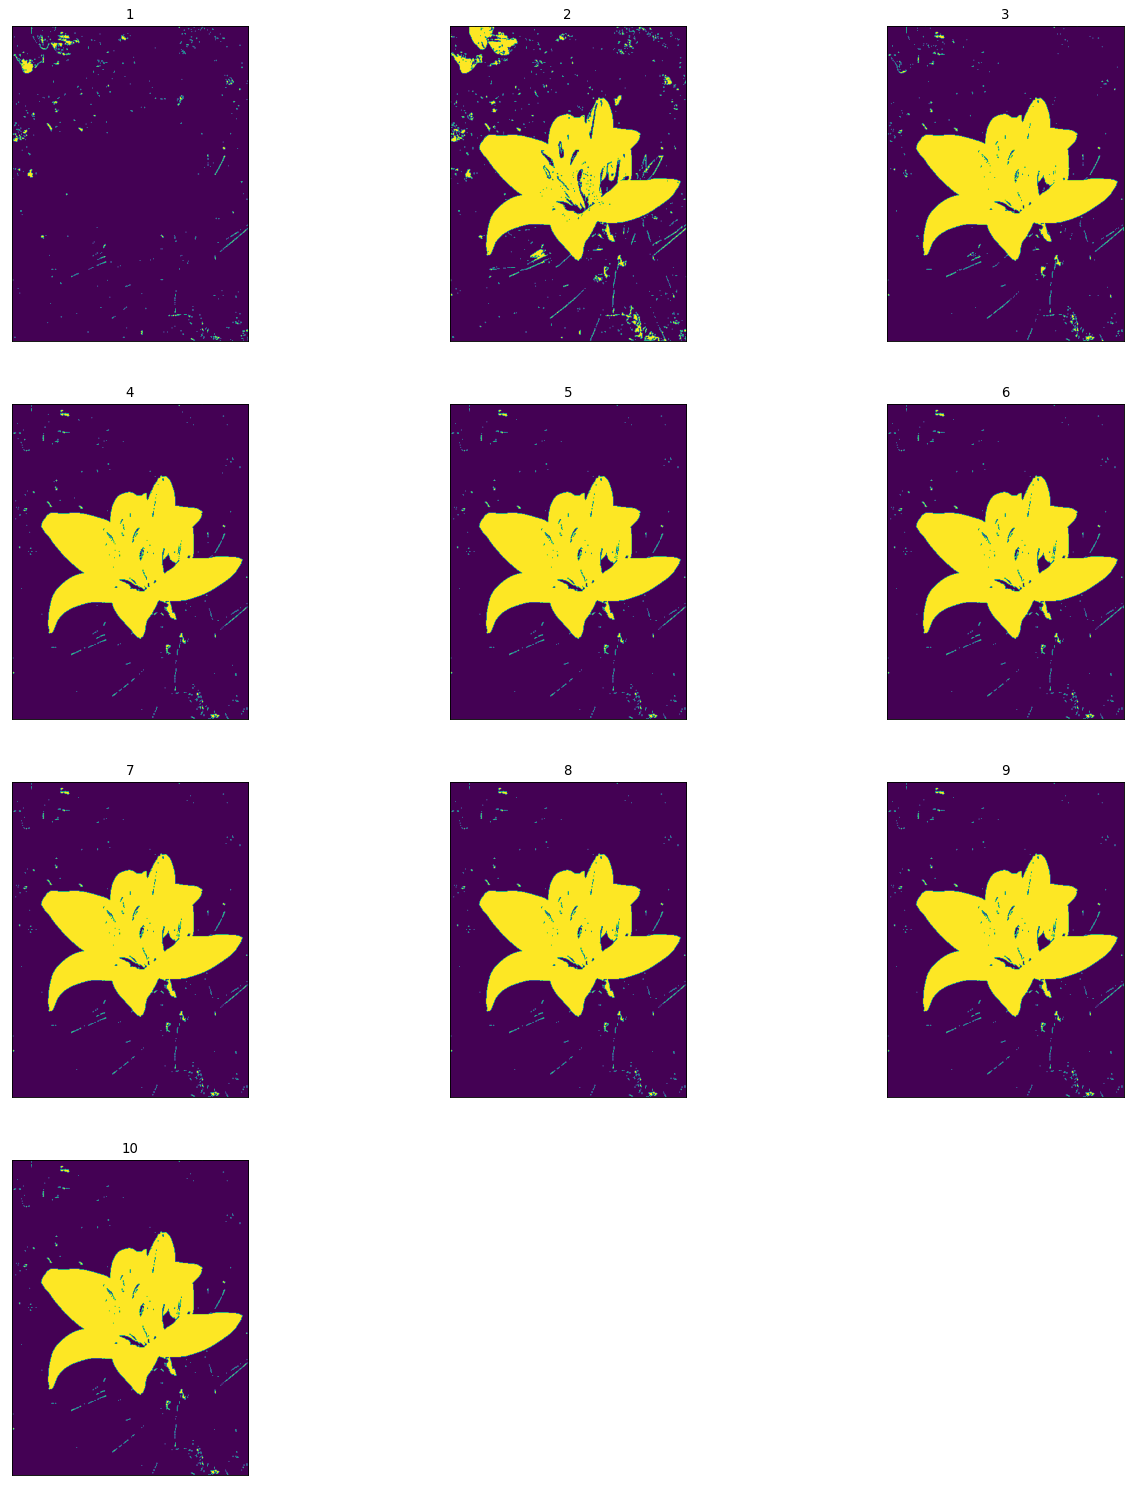

In [22]:
h, w, ch = img.shape
img = img.astype(np.float64)

# 2 randomly selected cluster centers
centers = [[random.uniform(0.0, 1.0)*255.0, random.uniform(0.0, 1.0)*255.0, random.uniform(0.0, 1.0)*255.0],
           [random.uniform(0.0, 1.0)*255.0, random.uniform(0.0, 1.0)*255.0, random.uniform(0.0, 1.0)*255.0]]

#print(centers)
img_iter = []
for i in range(10):
    #  distance between each pixel and center.
    diff = np.array([img - c for c in centers])
    diff = np.linalg.norm(diff, axis=-1)
 
    clusters = np.argmin(diff, axis=0)
    img_iter.append(clusters)

    # calculate new cluster centers.
    new_centers = np.zeros(shape=(2,ch))
    for j in range(2):
        new_centers[j] = np.mean(img[clusters == j], axis=0)
    centers = new_centers

#plot

fig=plt.figure(figsize=(20, 24), dpi= 80)
for i in range(10):
    plt.subplot(4,3,i+1), plt.imshow(img_iter[i].astype(np.uint8))
    plt.title(i+1)
    plt.xticks([]), plt.yticks([])
    
plt.show()



## 1.2 Expectation Maximization - Gaussian Mixture Models

In [4]:
org_img = cv2.imread('./yellowlily.png')
img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
h, w, ch = img.shape

## 1.3 Reasoning question

#### Under what data distribution conditions would K-means and EM give the same solution, provided similar initializations?

When the data points are clearly defined at to be part of one cluster or another, that is when there clear seperation between clusters, then K-means and EM provide similar solutions.

# 2 Stereo Vision - Epipolar Geometry

In [5]:
""" drawlines """
def drawlines(img1, img2, lines, pts1, pts2):
    """
    Draw epilines. Epilines corresponding to the points in 
    the first image are drawn on the second image.
    :param img1: image on which we draw the epilines for the points
            in img2
    :param lines: corresponding epilines
    """
    # img1 shape
    row, col = img1.shape
    # convert from grayscale to BGR
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    # for each line
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        # pick a random color
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2]/r[1]])
        x1, y1 = map(int, [col, -(r[2]+r[0]*col)/r[1]])
        # draw the lines and the points
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color, 1)
        img1 = cv2.circle(img1, tuple(pt1), 5, color, -1)
        img2 = cv2.circle(img2, tuple(pt2), 5, color, -1)
    return img1, img2

In [6]:
# read images
img_left = cv2.imread("im0.png", cv2.IMREAD_GRAYSCALE)
img_right = cv2.imread("im1.png", cv2.IMREAD_GRAYSCALE)


#### Compute SIFT keypoints from a stereo image pair

In [7]:
# create SIFT object
sift = cv2.xfeatures2d.SIFT_create()
#create brute forfce matcher object
bfMatcher = cv2.BFMatcher(cv2.NORM_L2)

# find keypoints and descriptor
kpL, desL = sift.detectAndCompute(img_left, None)
kpR, desR = sift.detectAndCompute(img_right, None)

# get matches
matches = bfMatcher.knnMatch(desL, desR, k=2)

#### Compute and display epipolar lines for both images

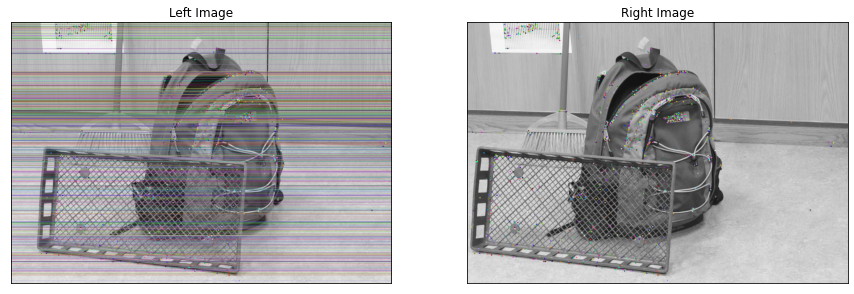

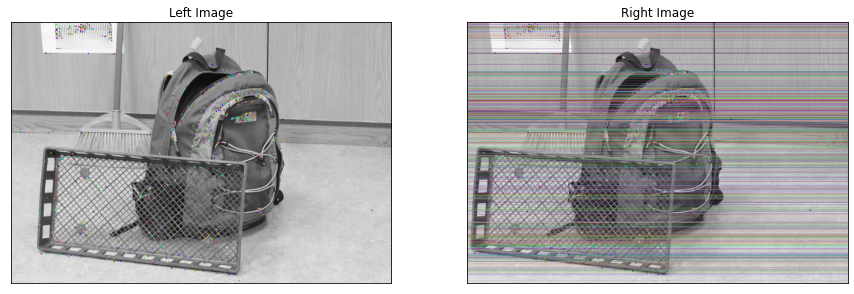

In [8]:
# ratio test - store the list of best matches from both images
good = []
ptsL = []
ptsR = []
for i, (m, n) in enumerate(matches):
    if m.distance < 0.6 * n.distance:
        good.append(m)
        ptsR.append(kpR[m.trainIdx].pt)
        ptsL.append(kpL[m.queryIdx].pt)

# find the Fundamental Matrix
ptsL = np.int32(ptsL)
ptsR = np.int32(ptsR)
F, mask = cv2.findFundamentalMat(ptsL, ptsR, cv2.FM_LMEDS) 


# Use only inliers for remaining computations
ptsL = ptsL[mask.ravel()==1]
ptsR = ptsR[mask.ravel()==1]

# epilines for left image on right image
linesL = cv2.computeCorrespondEpilines(ptsR, 2, F)
linesL = linesL.reshape(-1, 3)

# draw lines
imgL1, imgR1 = drawlines(img_left, img_right, linesL, ptsL, ptsR)

# epilines for right image on left image
linesR = cv2.computeCorrespondEpilines(ptsL, 1, F)
linesR = linesR.reshape(-1, 3)
# draw lines
imgR2, imgL2 = drawlines(img_right, img_left, linesR, ptsR, ptsL)

# display images
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL1, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR1, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.figure(figsize=(15,15))
plt.subplot(121), plt.imshow(imgL2, cmap="gray")
plt.title("Left Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(imgR2, cmap="gray")
plt.title("Right Image"), plt.xticks([]), plt.yticks([])
plt.show()

#### Pick any one keypoint in the left image which has a correct match in the right image, and is on the corresponding epipolar line. Extract a patch of size (5 x 5) around this keypoint in the left image. 

In [9]:
keypoint = ptsL[0]
print(keypoint)
x_s, x_e = keypoint[0] - (5//2), keypoint[0] + (5 - 5//2)
y_s, y_e = keypoint[1] - (5//2), keypoint[1] + (5 - 5//2)

extractedPatch = img_left[y_s:y_e, x_s:x_e]
display_left = cv2.circle(img_left.copy(), tuple(keypoint), 25, (255, 0, 0), -1)

[ 75 851]


#### Match the extracted patch to every 5 x 5 patch along the corresponding epipolar line in the right image. Use normalized cross correlation metric for matching. 

In [10]:
# extract 5x5 patches along epipolar line
patch_list = []
x, y = keypoint
h, w= img_right.shape
s, e = 5 // 2, 5 // 2 + 1

for col in range(s, w - e):
    patch = img_right[y-s:y+e,col-s:col+e]
    patch_list.append(patch)
    
max_vals = []
    
for patch in patch_list:
    res = cv2.matchTemplate(patch, extractedPatch, cv2.TM_CCORR_NORMED)
    _, max_val, _, _ = cv2.minMaxLoc(res)
    max_vals.append(max_val)
    
max_index = max_vals.index(max(max_vals))
best_match = patch_list[max_index]

#### Plot normalized cross correlation values (on y-axis) against index of the patch in the left image (on x-axis). Find the matching point with maximum normalized cross correlation value. Display found matching points in both the images.

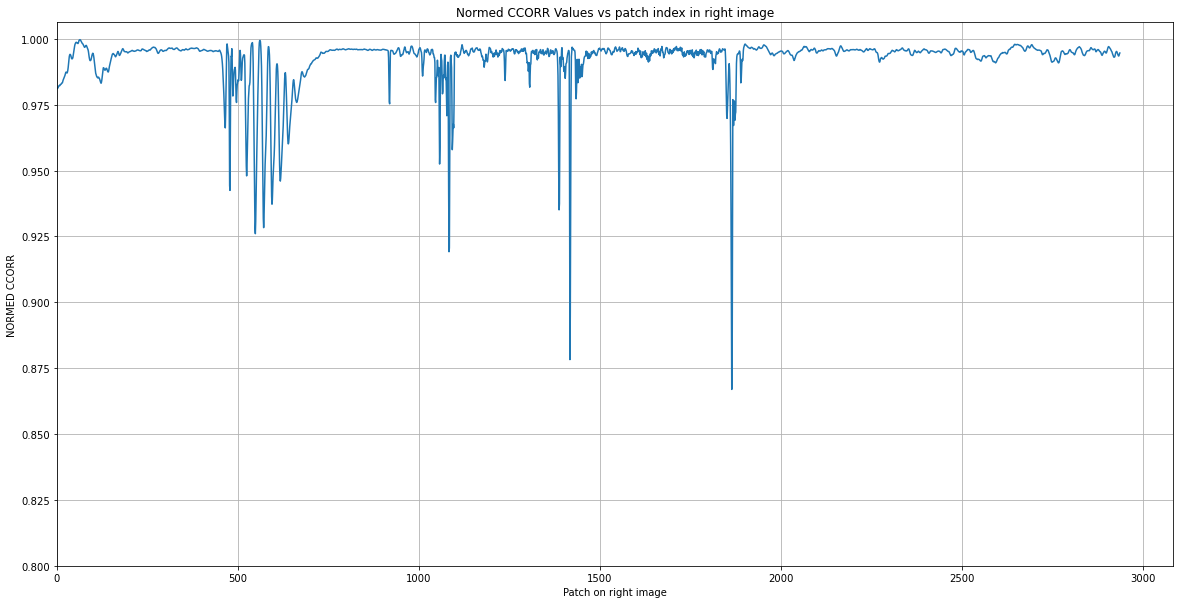

The center of the best_match patch is at column  62


In [11]:
# Plot Normed CCORR Values
patch_size = (5, 5)

plt.figure(figsize=(20,10))
plt.title("Normed CCORR Values vs patch index in right image")
plt.xlabel("Patch on right image")
plt.ylabel("NORMED CCORR")
x_axis = range(patch_size[0] // 2, img_right.shape[1] - patch_size[1] // 2 - 1)
plt.plot(x_axis, max_vals)
plt.ylim(ymin=0.8), plt.xlim(xmin=0)
plt.grid(True)
plt.show()

print("The center of the best_match patch is at column ",max_index)

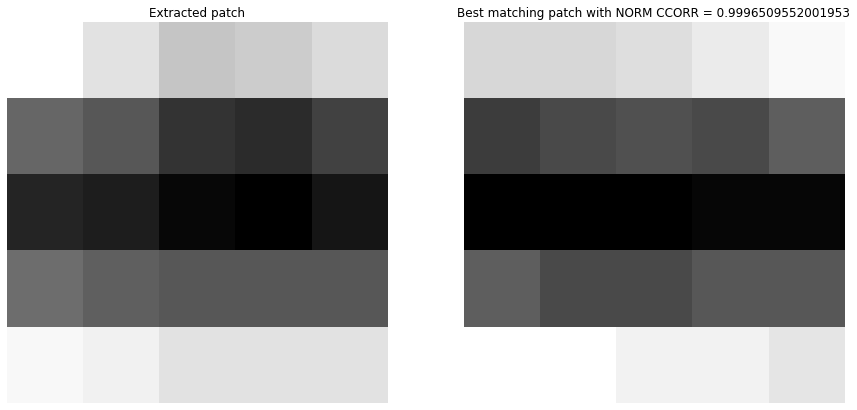

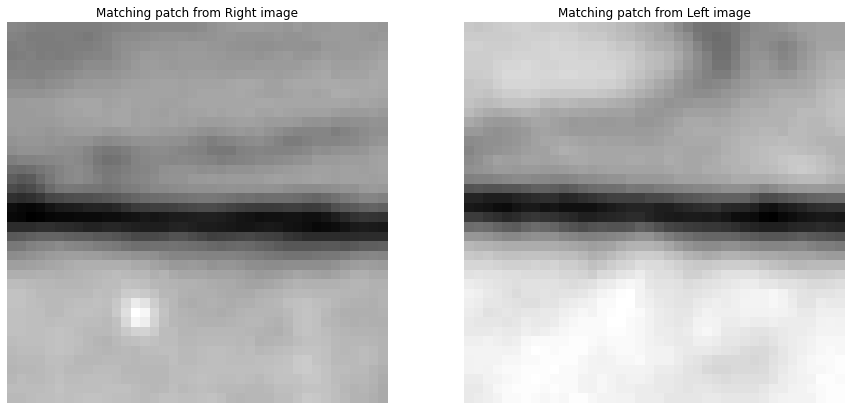

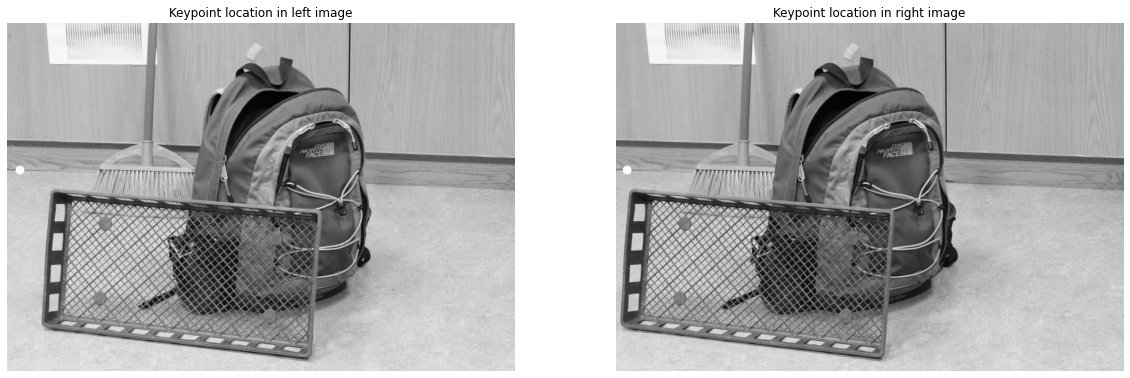

In [12]:
#extract larger patch to confirm

x, y = keypoint
best_match_patch_center = (max_index+5//2, y)

# Extract the larger patch to see context
x_s, x_e = x - (20), x + (20)
y_s, y_e = y - (20), y + (20)
imgR_extract = img_right[y_s:y_e, x_s:x_e]

x, y = best_match_patch_center
x_s, x_e = x - (20), x + (20)
y_s, y_e = y - (20), y + (20)
imgL_extract = img_left[y_s:y_e, x_s:x_e]

# mark keypoint in right image
display_right = cv2.circle(img_right.copy(), tuple(best_match_patch_center), 25, (255, 0, 0), -1)

# Display extracted small patches
plt.figure(figsize=(15,15))
plt.subplot(121), plt.title("Extracted patch")
plt.imshow(extractedPatch, cmap="gray"), plt.axis('off')
plt.subplot(122), plt.title("Best matching patch with NORM CCORR = {}".format(max_vals[max_index]))
plt.imshow(best_match, cmap="gray"), plt.axis('off')


# display larger patches for confirmation
plt.figure(figsize=(15,15))
plt.subplot(121), plt.title("Matching patch from Right image") 
plt.imshow(imgR_extract, cmap="gray"), plt.axis('off')
plt.subplot(122), plt.title("Matching patch from Left image") 
plt.imshow(imgL_extract, cmap="gray"), plt.axis('off')

# Display patches
plt.figure(figsize=(20,10))
plt.subplot(121), plt.title('Keypoint location in left image')
plt.imshow(display_left, cmap="gray"), plt.axis('off')
plt.subplot(122), plt.title('Keypoint location in right image'), plt.xticks([]), plt.yticks([])
plt.imshow(display_right, cmap="gray"), plt.axis('off')


plt.show()


#### Did you find exactly one matching point or multiple matches? Is the matching point you found the correct one? Explain.

Only one matching point is found. It is the patch with the highest normalized cross correlation. As can be seen in the images above with the keypoint marked in the left and right images,it is the correct one.

# 3 Motion Algorithm - Multi Resolution Lucas-Kanade Optical Flow Estimation

In [13]:
#read images
img1 = cv2.imread("frame1.png")
img2 = cv2.imread("frame2.png")

# convert to grayscale
img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

#### Extract good corners to track using the Harris corner detector

In [14]:
#paramaters for corner detector
feature_params = dict( maxCorners = 500,
                        qualityLevel = 0.1,
                        minDistance = 7,
                        blockSize = 7,
                        useHarrisDetector=True)

#find corners in the first image
p0 = cv2.goodFeaturesToTrack(img1_gray, **feature_params)
#p0 = cv2.cornerHarris(img1_gray, 2, 3, 0.04)

#### Compute the optical flow between the 2 frames

In [15]:
def findFlow(level):
    # parameters for lucas kanade optical flow
    lk_params = dict( winSize = (10,10),
                      maxLevel = level,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT,
                                 10, 0.03))

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(img1_gray, img2_gray, p0, None, **lk_params)


    # select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    #calculate mean of tracking error
    good_err = err[st==1]
    mean_err = sum(good_err)/len(good_err)

    print("Mean error : ", mean_err)

    # create some random colors
    color = np.random.randint(0, 255, (good_new.shape[0], 3))

    # create a mask image for drawing purposes
    mask = img1.copy()

    # draw the tracks
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.ravel()
        c, d = old.ravel()
        mask = cv2.line(mask, (a,b), (c,d), color[i].tolist(), 2)

    # display images
    plt.figure(figsize=(10,10))
    plt.imshow(mask)
    plt.title("Optical Flow with pyramid level = {}".format(level)), plt.xticks([]), plt.yticks([])
    plt.show()
    
    return mean_err

#### Display the optical flow for each setting of maximum pyramid level.

Mean error :  6.0461700711139414


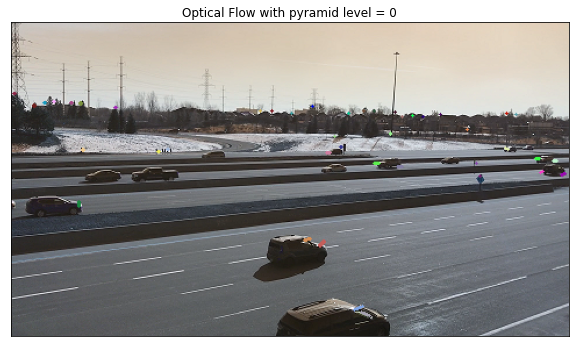

Mean error :  4.3198288423674445


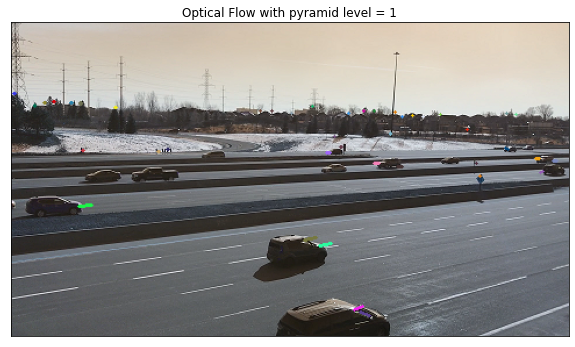

Mean error :  3.73380955911818


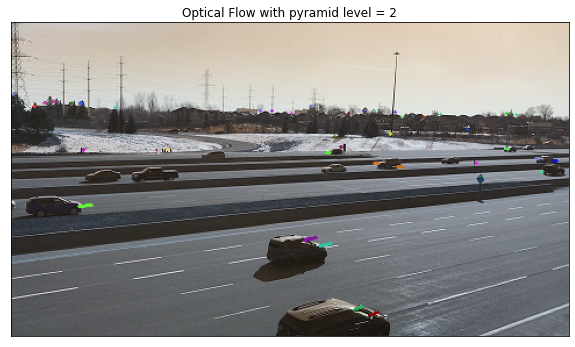

Mean error :  3.730639866420201


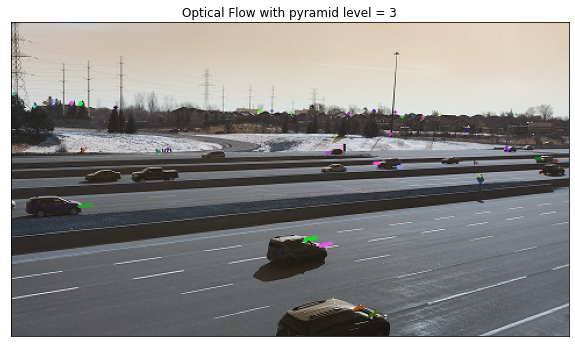

Mean error :  3.733184527783167


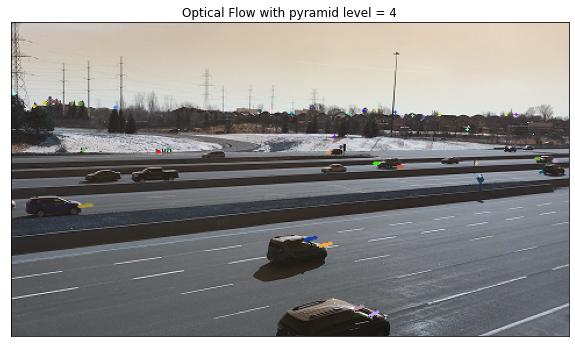

Mean error :  3.733184527783167


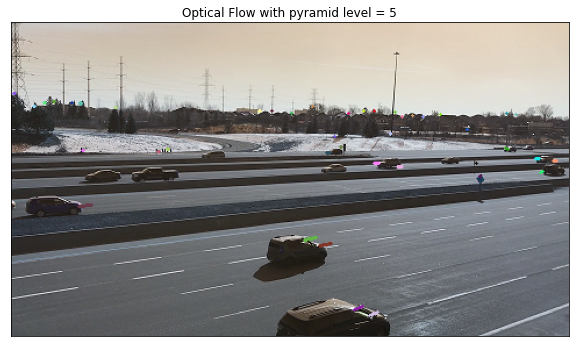

Mean error :  3.733184527783167


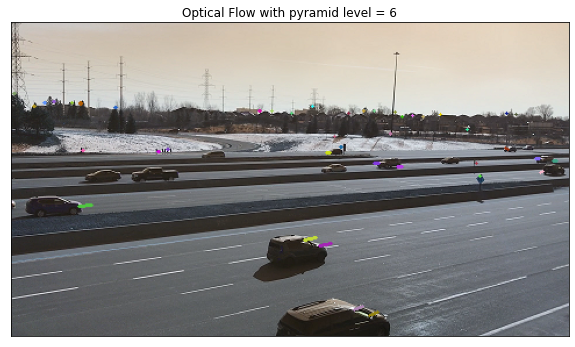

Mean error :  3.733184527783167


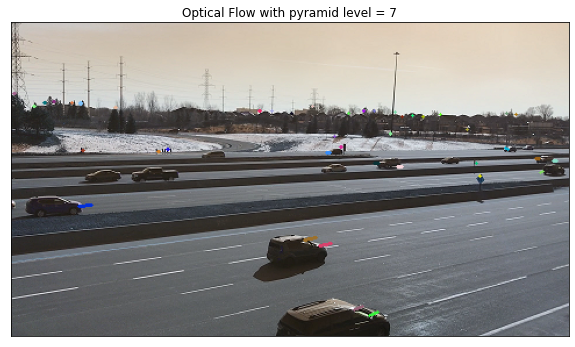

Mean error :  3.733184527783167


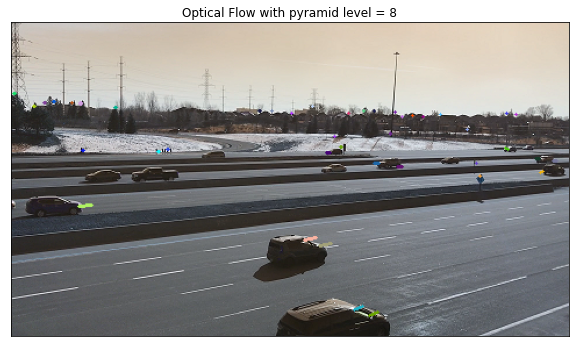

Mean error :  3.733184527783167


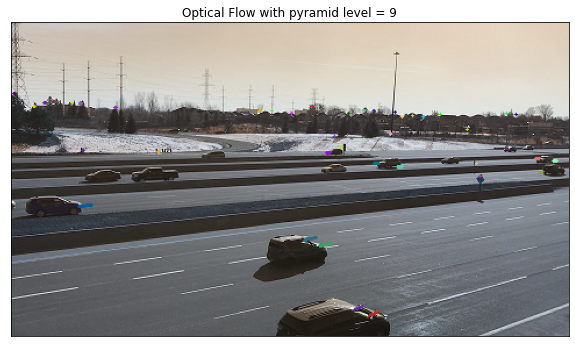

Mean error :  3.733184527783167


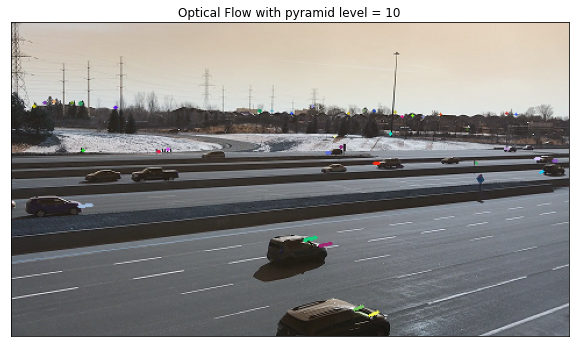

In [16]:
error = []
level = []

for i in range(11):
    error.append(findFlow(i))
    level.append(i)

The best results are obtained with the maximum pyramid level set to greater than or equal to 2.

#### Plot the mean of the error vs the pyramid level

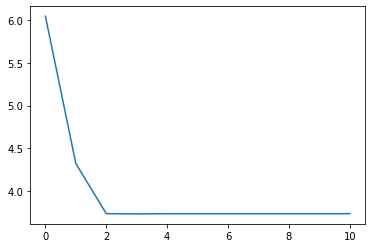

In [17]:
plt.plot(level, error)

As can be seen in the plot above, the mean error only reduces up until a certian point, max pyramid level = 2 in this case. Increasing the levels beyond this point does not give us any further improvements in resuts with respect to the mean error.